In [293]:
from scipy.signal import savgol_filter
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
import scipy as sp

# load raw data and visualize

In [294]:
title = 'stopshot-6'
filepath = f'/content/drive/MyDrive/eksperimen fisika/stopshot/csv/{title}.csv'
cue_pos = 57 # cm

In [295]:
# load data
df = pd.read_csv(filepath)
df.head()

,frame,x
0,0,0.191296
1,1,0.191296
2,2,0.191296
3,3,0.190868
4,4,0.191185


In [296]:
# take the relevant columns
df = df[['frame', 'x']]
df.head()

,frame,x
0,0,0.191296
1,1,0.191296
2,2,0.191296
3,3,0.190868
4,4,0.191185


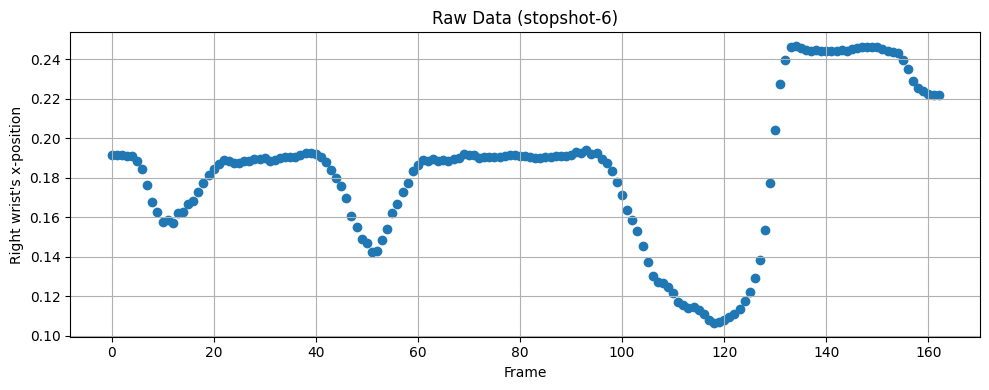

In [297]:
# visualize raw data
plt.figure(figsize=(10, 4))
plt.title(f'Raw Data ({title})')
plt.scatter(df['frame'], df['x'])
plt.xlabel('Frame')
plt.ylabel("Right wrist's x-position")
plt.grid(True)
plt.tight_layout()
plt.show()

# change the units of axes to physical units

In [298]:
#  cue length is normally 58 inches = 147.32 cm
cue_length_cm = 147.32


# calculating span of video in cm
cue_px_raw = 418 # px (length of cue in pixels spanned on original unprocessed video)
vid_width_raw = 848 # px (width of original unprocessed video)
vid_width_cm = cue_length_cm * (vid_width_raw / cue_px_raw)

# calculating x-displacement of right wrist in centimeters
x_cm = df['x'] * vid_width_cm
df['x (cm)'] = x_cm

# calculte the seconds
fps = 30.0
df['time (s)'] = df['frame'] / fps

# display the result
df.head()

,frame,x,x (cm),time (s)
0,0,0.191296,57.172580,0.000000
1,1,0.191296,57.172580,0.033333
2,2,0.191296,57.172580,0.066667
3,3,0.190868,57.044592,0.100000
4,4,0.191185,57.139338,0.133333


# pre-process data for analysis

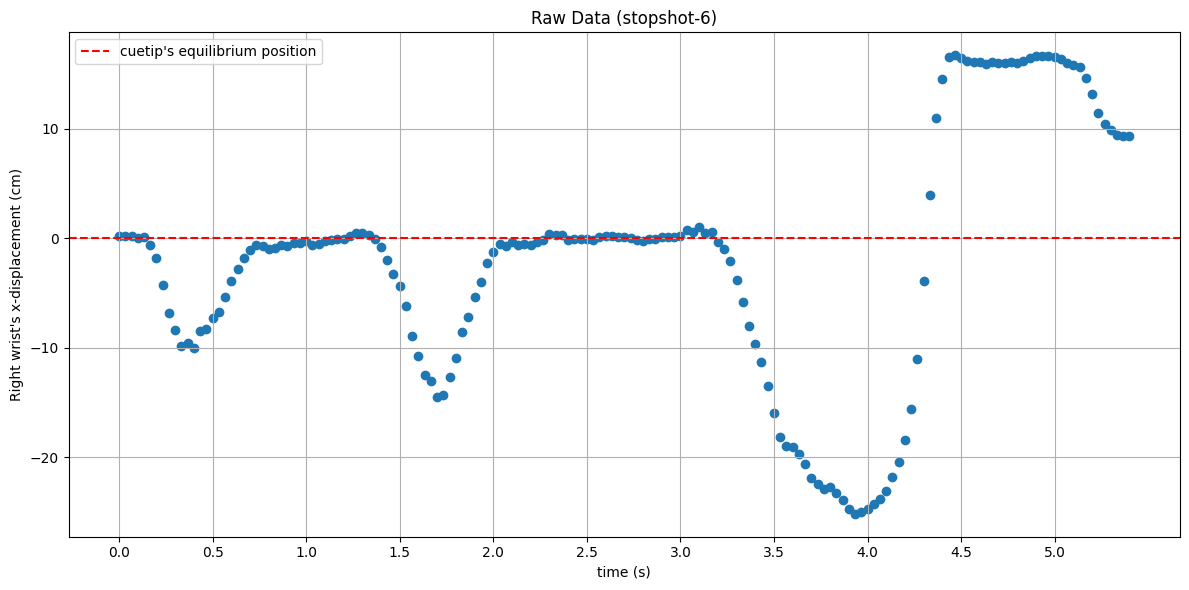

In [299]:
# CLEANING DATA FROM UNWANTED POINTS

# condition_frame = (175 < positions['frame']) & (positions['frame'] < 185)
# condition_x = (positions['x'] < 0.29)
# positions = positions[~(condition_x & condition_frame)]

# condition_frame = (50 < positions['frame']) & (positions['frame'] < 75)
# condition_x = (positions['x'] < 0.12)
# positions = positions[~(condition_x & condition_frame)]



# condition_frame = (positions['frame'] < 25)
# condition_x = (positions['x'] > 0.1)
# positions = positions[~(condition_x & condition_frame)]

# condition_frame = (df['frame'] < 90)
# df = df[(condition_frame)]

# positions = positions[(0.1 < positions['x']) & (positions['x'] < 0.23)]

# positions = positions[(0.09 < positions['x']) & (positions['x'] < 0.21)]

plt.figure(figsize=(12, 6))
plt.grid(True)
plt.title(f'Raw Data ({title})')
plt.scatter(df['time (s)'], df['x (cm)']-cue_pos)
plt.xlabel('time (s)')
plt.ylabel("Right wrist's x-displacement (cm)")
# plt.ylim((-23,np.max(df['x (cm)'])-cue_pos+2))
plt.axhline(y=0, color='r', linestyle='--', label="cuetip's equilibrium position")
plt.xticks(np.arange(0, df['time (s)'].iloc[-1], 0.5))
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig(f'/content/drive/MyDrive/eksperimen fisika/stopshot/csv/{title}-raw', dpi=300)
plt.show()


if there's an initial camera movement, run this script to remove it. If the data looks okay, skip ahead

In [300]:
# # account for camera movement
# df = df.drop_duplicates(subset=['frame'], keep='first')
# frame_limit = 60

# y_init = 0.190 - 0.110
# b = -1 * np.log(0.1) / frame_limit
# mask = df['frame'] < frame_limit

# # Calculate the camera movement correction (linear adjustment) for the relevant times
# # exponential decay
# # y = A e^(-b(x - x0))
# camera_movement_correction = y_init * np.exp(-1 * b * (df.loc[mask, 'frame'] + 5))

# # Apply the correction to the 'x' position for the masked times
# df.loc[mask, 'x'] += camera_movement_correction

# plt.figure(figsize=(12, 6))
# plt.scatter(df['frame'], df['x'], label='Corrected x position')
# plt.plot(df.loc[mask, 'frame'], camera_movement_correction, 'r--', label='Applied exponential decay Camera Correction')
# plt.title('Corrected X Position of Right Wrist vs Frame')
# plt.xlabel('Frame')
# plt.ylabel('Corrected X Position')
# plt.grid(True)
# plt.legend()
# plt.show()

# print("First few rows of corrected positions:")
# print(df.head())

## apply moving average for initial data smoothing

/tmp/ipython-input-2882823100.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  position.iloc[:] = df['x (cm)'].iloc[:].rolling(window=4).mean().fillna(method='bfill').fillna(method='ffill')


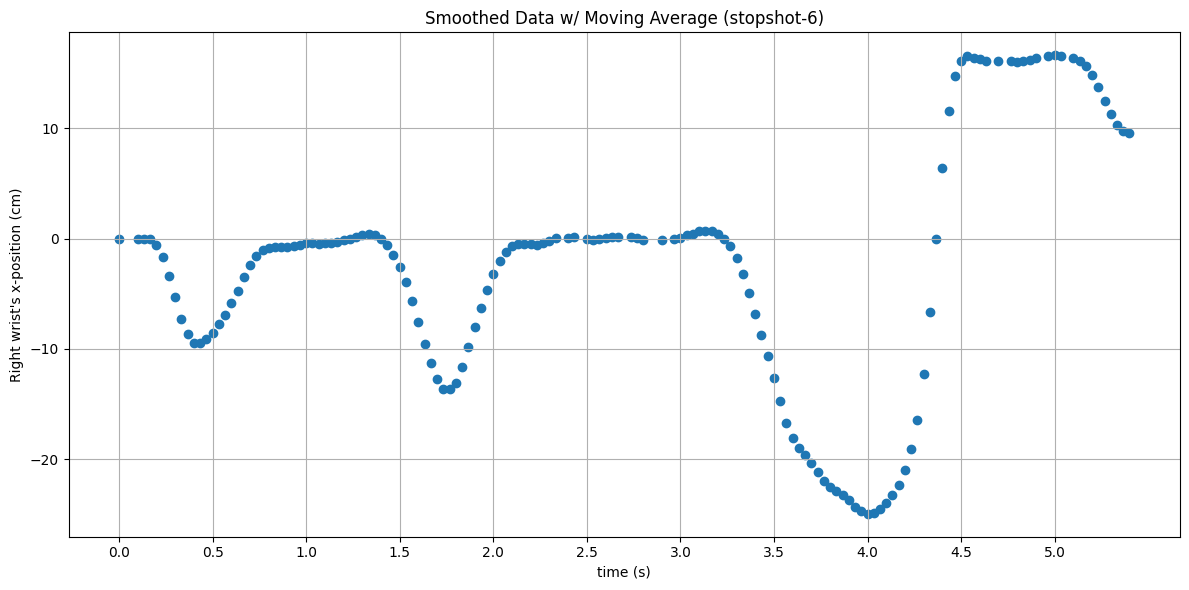

# times = 151
# position = 151


In [301]:
df = df.drop_duplicates(subset=['x (cm)'], keep='first')

times = df['time (s)']
position = df['x (cm)']
# moving average on subset of position dataframe, then replace the old values of the subset
position.iloc[:] = df['x (cm)'].iloc[:].rolling(window=4).mean().fillna(method='bfill').fillna(method='ffill')
# position.iloc[:120] = positions['x'].iloc[:120].rolling(window=5).mean().fillna(method='bfill').fillna(method='ffill')
# position.iloc[170:200] = positions['x'].iloc[170:200].rolling(window=5).mean().fillna(method='bfill').fillna(method='ffill')


plt.figure(figsize=(12, 6))
plt.grid(True)
plt.scatter(times, position-cue_pos)
plt.title(f'Smoothed Data w/ Moving Average ({title})')
plt.xlabel('time (s)')
plt.ylabel("Right wrist's x-position (cm)")
plt.tight_layout()
plt.xticks(np.arange(0, times.iloc[-1], 0.5))
plt.savefig(f'/content/drive/MyDrive/eksperimen fisika/stopshot/csv/{title}-movAvg', dpi=300)
plt.show()

print('# times =', len(times))
print('# position =', len(position))

## apply cubic spline interpolation, then savgol filter


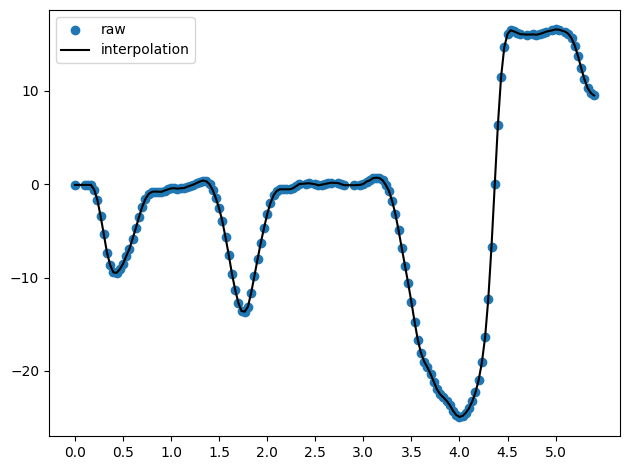

In [302]:
times, position = np.array(times), np.array(position) - cue_pos

f = sp.interpolate.CubicSpline(times, position)
splines = f(times)


plt.scatter(times, position, label='raw')

plt.plot(times, splines, 'black', label='interpolation')
plt.tight_layout()
plt.legend()
plt.xticks(np.arange(0, times[-1], 0.5))
plt.grid()
plt.show()

<Figure size 1200x600 with 0 Axes>

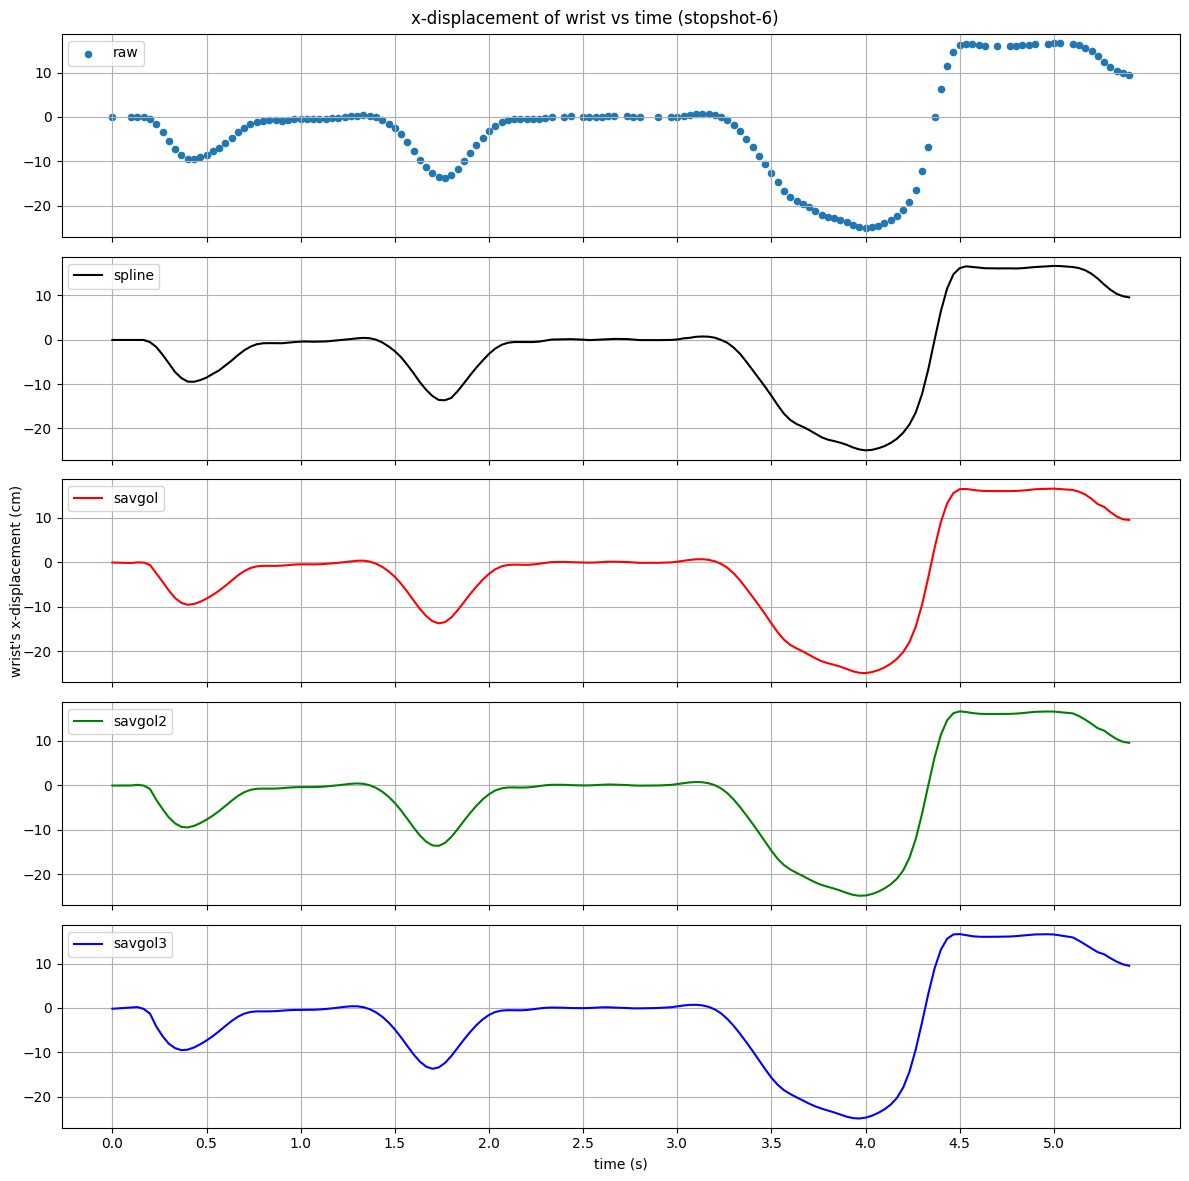

In [303]:
# smoothing data, and plotting

smooth1 = savgol_filter(splines, 10, 4)
smooth2 = savgol_filter(smooth1, 10, 4)
smooth3 = savgol_filter(smooth2, 10, 4)

plt.figure(figsize=(12, 6))
plt.rcParams['axes.grid'] = True
fig, axes = plt.subplots(5, 1, figsize=(12, 12), sharex=True)
fig.suptitle(f'x-displacement of wrist vs time ({title})')

axes[0].set_xticks(np.arange(0, times[-1], 0.5))



axes[0].scatter(times, position, s=20, label='raw')
axes[1].plot(times, splines, 'black', label='spline')
axes[2].plot(times, smooth1, 'red', label='savgol')
axes[3].plot(times, smooth2, 'green', label='savgol2')
axes[4].plot(times, smooth3, 'blue', label='savgol3')


axes[0].legend(loc='upper left')
axes[1].legend(loc='upper left')
axes[2].legend(loc='upper left')
axes[3].legend(loc='upper left')
axes[4].legend(loc='upper left')

axes[4].set_xlabel('time (s)')

axes[2].set_ylabel("wrist's x-displacement (cm)", va='center', rotation='vertical')
plt.tight_layout()
plt.savefig(f'/content/drive/MyDrive/eksperimen fisika/fedorGorst/{title}-spline-savgol', dpi=300)
plt.show()

# Now this is the analysis part

## computing velocity and acceleration, then visualizing

In [304]:
# POSITION (cm)
wrist_pos = smooth3
times = times

# VELOCITY (v = dx/dt) (m/s)
v = np.gradient(wrist_pos, times) / 100
# for _ in range(3):
#   v = savgol_filter(v, 15, 4)

# ACCELERATION (a = dv/dt) (m^2/s)
a = np.gradient(v, times)
# for _ in range(3):
#   a = savgol_filter(a, 15, 4)

# during maximum speed
t_max = times[np.argmax(v)]
print("t_max =", t_max, "s")
v_max = np.max(v)
print("v_max =", v_max, "m/s")

t_max = 4.3 s
v_max = 1.8789435452631016 m/s


<Figure size 1200x600 with 0 Axes>

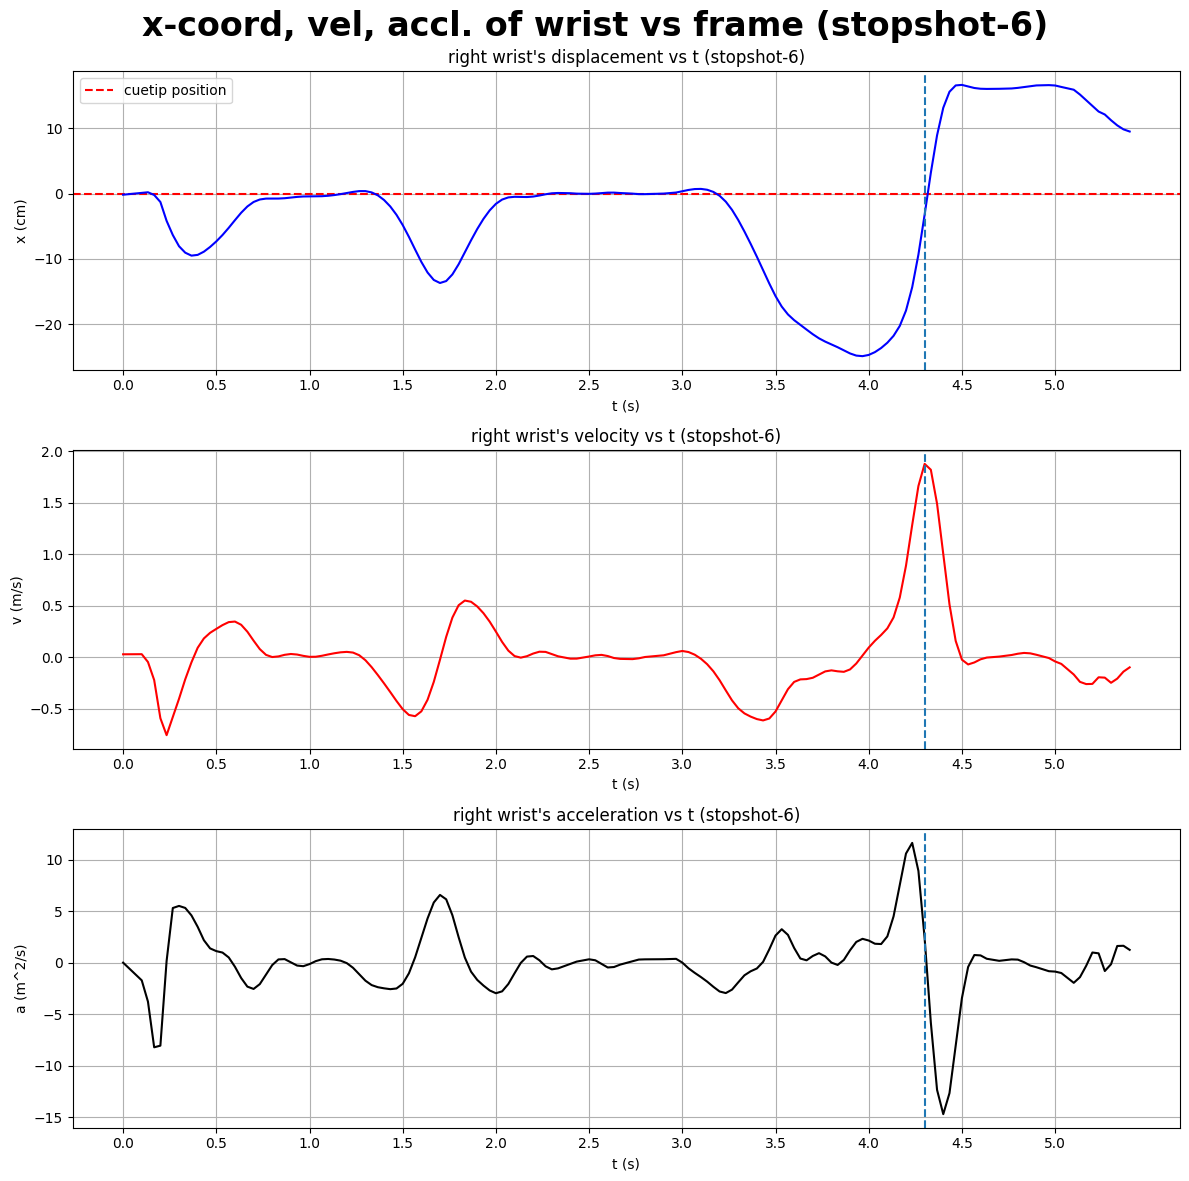

In [305]:
plt.figure(figsize=(12, 6))
plt.rcParams['axes.grid'] = True
fig, axes = plt.subplots(3, 1, figsize=(12, 12))
fig.suptitle(f'x-coord, vel, accl. of wrist vs frame ({title})', size=24, weight="bold")

axes[0].axhline(y=0, color='r', linestyle='--', label='cuetip position')
axes[0].legend(loc='upper left')

xlabel = 't (s)'
ylabels = ["x (cm)", "v (m/s)", "a (m^2/s)"]
x_value = times
y_values = [wrist_pos, v, a]
sub_titles = ["right wrist's displacement vs t",
              "right wrist's velocity vs t",
              "right wrist's acceleration vs t"]
colors = ["blue", "red", "black"]

for i in range(3):
  axes[i].set_title(sub_titles[i] + f" ({title})")
  axes[i].set_xlabel(xlabel)
  axes[i].set_ylabel(ylabels[i])
  axes[i].plot(x_value, y_values[i], colors[i])
  axes[i].axvline(t_max, linestyle='--')
  axes[i].set_xticks(np.arange(0, times[-1], 0.5))


plt.tight_layout()
plt.savefig(f'/content/drive/MyDrive/eksperimen fisika/stopshot/csv/{title}-xvat', dpi=300)
plt.show()







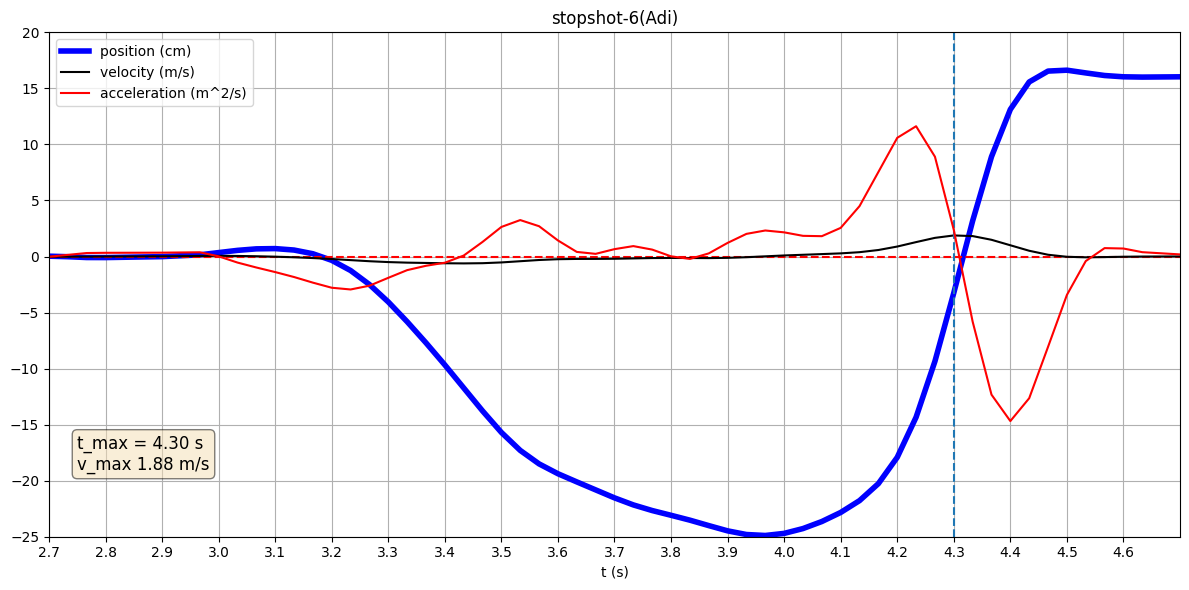

In [309]:
# ON ONE GRAPH
plt.figure(figsize=(12,6))
plt.title(title + "(Adi)")


# position
plt.plot(times, wrist_pos, 'blue', linewidth=4, label='position (cm)')
plt.axhline(y=0, color='r', linestyle='--')


# velocity
plt.plot(times, v, 'black', label='velocity (m/s)')
plt.axvline(t_max, linestyle='--')

# acceleration
plt.plot(times, a, 'red', label='acceleration (m^2/s)')

plt.xlabel('t (s)')
plt.legend(loc="upper left")
plt.tight_layout()
(x_bottom, x_upper) = (2.7, 4.7)
plt.xticks(np.arange(x_bottom, x_upper, 0.1))
plt.xlim((x_bottom, x_upper))
plt.ylim(-25, 20)
plt.grid(True)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(x_bottom + 0.05, -19, f"t_max = {t_max:.2f} s \nv_max {v_max:.2f} m/s", fontsize=12, bbox=props)


plt.savefig(f'/content/drive/MyDrive/eksperimen fisika/stopshot/csv/{title}-zoom', dpi=300)
plt.show()

In [310]:
df.head()
df.to_csv(f'/content/drive/MyDrive/eksperimen fisika/stopshot/csv/{title}-physical.csv')